# F1 Tire Friction Analysis

## Introduction

In this analysis, we will explore the tire friction characteristics of Formula 1 cars. The friction between the tires and the track surface is crucial for performance, affecting acceleration, braking, and cornering. We are going to analyze the speed of which the tires pass through corners of the track, to try to understand how tire friction impacts lap times, and maybe even predict the fastest performance, based on when they last pitted.

Below is a visualization of the formula 1 track, from the british grand prix of 2025. In order to understand the tire friction, we will explore the velocity of the racers, going through corner 15 of the track. Corner 15 is a right-handed corner. Both the entry and exit of the corner are at high speeds, because of the long straights before and after the corner. This makes the corner particularly interesting for analyzing tire friction, as it allows the racers to maintain the highest possible speeds while navigating the turn, and this is crucial for our mission of finding the friction coefficients of the tires.

To find the friction coefficients, we will combine some physics with a linear regression model. This allows us to estimate the tire friction based on the speed of the cars as they navigate through corner 15. As well as it gives us the ability to predict outcomes.

The data we will use is from the 2025 British Grand Prix. We have collected the distance traveled by the cars, as well as the time they have used to reach said distance. We have this data for lap 48 to 52, for all the qualifying racers. The reason for this choice in laps is that they are the last few laps, where the best racers are trying to set their fastest times, ensuring that they drive as fast as possible through the corners.

![British Grand Prix Circuit with Corners](Racing_track.png)

### Importing the data
The data is stored in a pkl file, which is already preprocessed and ready to be used.

In [36]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [37]:
# read Racing_Data.pkl file
with open('Racing_Data.pkl', 'rb') as f:
    Racing_data = pickle.load(f)


The retrieved data is now stored in the following format:

```python
RaceData =
{
    'Racer1_key': { #Racer key, such as 'VER' for Verstappen, 'HAM' for Hamilton, etc.
        48: {  # Lap number
            'distance': [list of distances for lap 48], #distance in meters
            'time': [list of times for lap 48] #time in seconds
        }
        49: {
            'distance': [list of distances for lap 49],
            'time': [list of times for lap 49]
        },
        50: {...},
        51: {...},
        52: {...}
    }
    'Racer2_key': ...
}
```
To get all the racer keys, you can use the following code:

```python
racer_keys = list(RaceData.keys())
```
and to get the data for a specific racer, you can use:

```python
racer_data = RaceData['Racer1_key']
```
This will give you the data for the specified racer, which you can then use for further analysis

## 1) Find the velocities

In order to get started on our analysis, we will first need to add the velcities to the data. The `distance` and `time` data are provided, and it is made so that `distance[i]` corresponds to `time[i]`. Meaning you can find the velocity at each point in time by deriving the distance with respect to time. The velocity can be calculated using the formula:
$$
v_i = \frac{∂ d_i}{∂t_i} = \frac{d_{i+1} - d_i}{t_{i+1} - t_i}
$$

### 1a) Create a function to calculate velocities

The first thing we will do is to create a function that inputs a racers data and returns the data with a new key `velocity`, which contains the velocities for each lap and each point in time. The function will iterate through the laps and calculate the velocities using the formula above.

In [ ]:
def find_velocities(racer: dict) -> dict:
    """
    Function returns the racer's data with velocities calculated for each lap.
    Velocities are calculated as the time derivative of the distance data.

    Parameters:
    -----------
    racer (dict): The racer's data containing lap information.

    Returns:
    -----------
    racer (dict): The updated racer data with velocity information added.
    """

    for lap in racer: #Loop over each lap in the racer's data
        distances = np.array(racer[lap]["distance"]) #Convert to numpy array for easier calculations
        times = np.array(racer[lap]["time"]) #Convert to numpy array

        velocities = np.zeros_like(distances) # Initialize velocities array with zeros


        for i in range(len(distances) - 1):
            velocities[i] = (distances[i + 1] - distances[i]) / (times[i + 1] - times[i])
        
        velocities[-1] = velocities[-2] # Last velocity is set to the second last to avoid index error
        racer[lap]["velocity"] = velocities # Assign calculated velocities to the racer data
        racer[lap]["distance"] = distances # Switch distances to numpy array for consistency
        racer[lap]["time"] = times # Switch times to numpy array for consistency
        
    return racer


for racer in Racing_data:
    Racing_data[racer] = find_velocities(Racing_data[racer])

### 1b) Average Velocity 

Now, we will move on to the chosen corner. Corner 15 starts at a distance approximately 4840 meters into the lap, and ends at approximately 5150 meters. 

In this subsection, you will first be tasked with finding the start and end indices of to corner, in order to complete the velocity plot below. This will show us how the racers' velocities change as they approach, drive through, and exit corner 15.

Next you are tasked with filling in the functions `find_start_end_indices(data, racer_key, lap_number, start_of_corner, end_of_corner)` and `average_velocity(data, racer_key, lap_number, start_index, end_index)` to facilitate this analysis.
The `find_start_end_indices` is needed in order to find exactly at what point in the lap, a racer enters and exits the corner, and the `average_velocity` function is needed to calculate the average velocity of the racer through the corner.

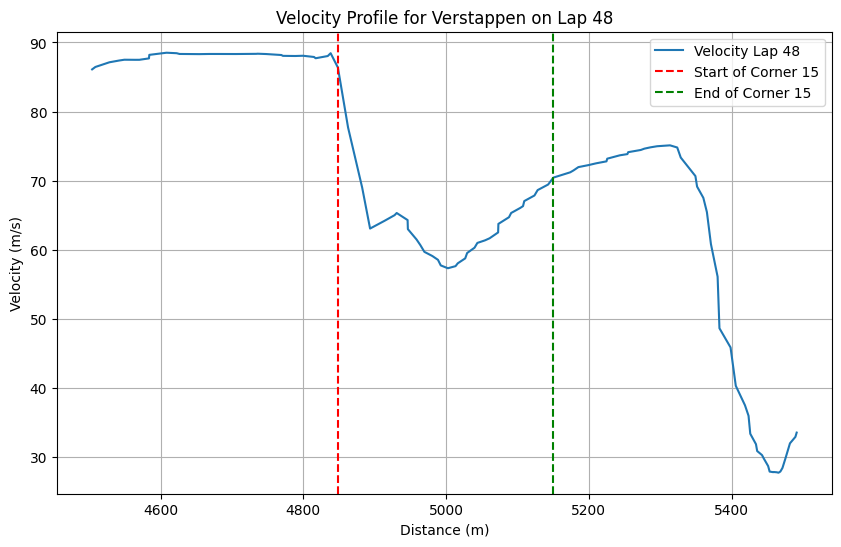

In [39]:
start_of_corner_15 = 4840
end_of_corner_15 = 5150
 
racer_name = "Verstappen"
racer_key = "VER"
lap_number = 48


distances = Racing_data[racer_key][lap_number]["distance"]
velocities = Racing_data[racer_key][lap_number]["velocity"]


left_idx = np.where(distances >= 4500)[0][0]
right_idx = np.where(distances <= 5500)[0][-1]

start_idx = np.where(distances >= start_of_corner_15)[0][0]
end_idx = np.where(distances >= end_of_corner_15)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(distances[left_idx:right_idx], 
         velocities[left_idx:right_idx], 
         label=f"Velocity Lap {lap_number}")

plt.axvline(x=distances[start_idx], 
            color='red', linestyle='--', label='Start of Corner 15')

plt.axvline(x=distances[end_idx], 
            color='green', linestyle='--', label='End of Corner 15')

plt.title(f"Velocity Profile for {racer_name} on Lap {lap_number}")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
def find_start_end_indices(data:dict, racer_key:str, lap_number:int, start_of_corner:float, end_of_corner:float) -> tuple:
    """Find the start and end indices for a given racer, lap and corner distance range.
    
    Parameters:
    -----------
    data (dict): The racing data containing distances.
    racer_key (str): The key for the racer in the data.
    lap_number (int): The lap number to analyze.
    start_of_corner (float): The starting distance of the corner.
    end_of_corner (float): The ending distance of the corner.

    Returns:
    -----------
    start_index, end_index (tuple): A tuple containing the start and end indices for the corner.

    """
    distances = data[racer_key][lap_number]["distance"]
    
    start_index = np.where(distances >= start_of_corner)[0][0]
    end_index = np.where(distances >= end_of_corner)[0][0]
    
    return start_index, end_index


def average_velocity(data:dict, racer_key:str, lap_number:int, start_index:int, end_index:int) -> float:
    """Calculate the average velocity for a given racer, lap and distance range.
    
    Parameters:
    ------------
    data (dict): The racing data containing velocities.
    racer_key (str): The key for the racer in the data.
    lap_number (int): The lap number to analyze.
    start_index (int): The starting index for the distance range.
    end_index (int): The ending index for the distance range.

    Returns:
    -----------
    v (float): The average velocity over the specified distance range.
    
    """
    velocities = data[racer_key][lap_number]["velocity"]

    return np.mean(velocities[start_index:end_index])

### 1c) Plot the average velocities through corner 15

In this section, you will plot the average velocities of the racers through corner 15. You will have to loop over each racer, and then use a nested loop to iterate over each lap. For each lap, you will use the `find_start_end_indices` function to find the start and end indices of the corner, and then use the `average_velocity` function to calculate the average velocity through the corner. We will use this to visualize how the the velocities, as a function of the lap number, change for each racer. This will give us an idea of how the racers are performing through corner 15, and how their tire friction is affecting their speeds.

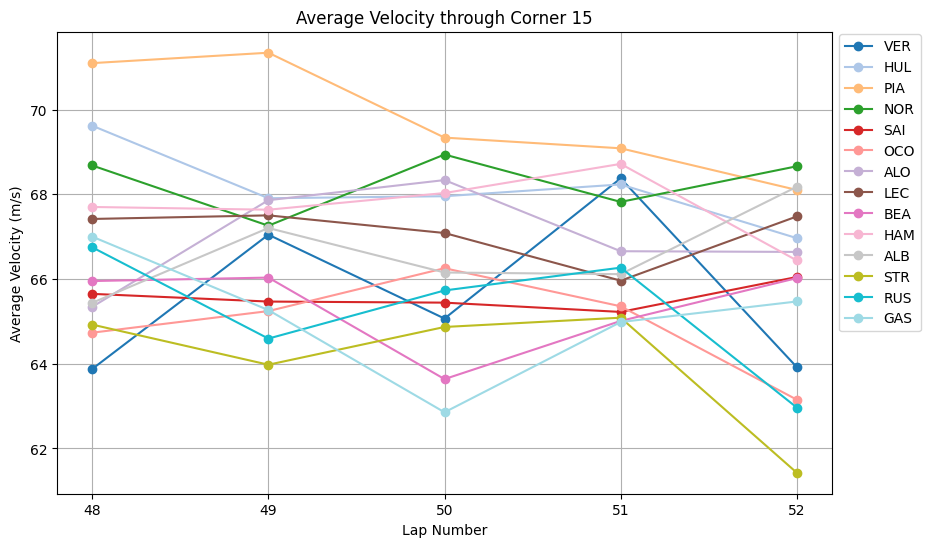

In [41]:
colors = plt.cm.tab20(np.linspace(0, 1, len(Racing_data)))

plt.figure(figsize=(10, 6))

for i, racer in enumerate(Racing_data):
    color = colors[i]
    laps = []
    velocities = []
    for lap in sorted(Racing_data[racer]):  # Ensure laps are in order
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,
            end_index=end_idx
        )
        laps.append(lap)
        velocities.append(velocity)
    plt.plot(laps, velocities, '-o', color=color, label=racer)

plt.xlabel("Lap Number")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity through Corner 15")
plt.legend(ncol=1, bbox_to_anchor=(1, 1.01))
plt.xticks([48,49,50,51,52])
plt.grid()
plt.show()

## 2) OLS (Ordinary Least Squares)

**What is Ordinary Least Squares?**

Ordinary Least Squares (OLS) is a method for estimating the unknown parameters in a linear regression model. It does this by minimizing the sum of the squares of the differences, which you can think of as the error, between the observed and predicted values. OLS is widely used in statistical modeling and machine learning for its simplicity and effectiveness in fitting linear relationships.

If you have some dots on a graph, in our case, the dots are the velocities on the y-axis vs lap number on the x-axis. The dots are not perfectly aligned, but we believe that they follow a trend, either increase or decrease, or maybe even a curve.

What we want to do is to draw a line that "fits" the dots as closely as possible. This line would help us describe the trend, and also make predictions about future values, like what the velocity might be on the next few laps. OLS does this by finding the best-fitting line that minimizes the distance between the line and all the dots.

**What does "best-fitting line" mean?**

Let's say you draw *any* line. Some dots will be above it, and some will be below. The difference between each dot and the line is called the **error** or **residual**. 

What OLS is saying is: "Let's choose the line that makes the sum of the squares of these errors as small as possible.". And that is why it is called least squares. The reason we square the errors is to make sure that positive and negative errors do not cancel each other out, while at the same time punishes larger errors more heavily.

**How to use OLS**
We want to fit a line of the form:
$$ \hat{y} = β_0 + β_1 x$$
where
- $ \hat{y} $ is the predicted value (velocity, in our case),
- $ x $ is the independent variable (in our case, lap number),
- $ β_0 $ is the y-intercept (the predicted value when lap number is 0),
- $ β_1 $ is the slope of the line (the change in predicted value for each additional lap).

OLS gives us the values of $ β_0 $ and $ β_1 $ that best fits the data.
The solution becomes:
$$
β = (X^T X)^{-1} X^T y
$$

where:
- $ X $ is the matrix of your inputs (lap numbers, plus a column of ones for the intercept),
- $ y $ is the column vector of observed values (velocities)


### 2a) Create a function to calculate OLS

You are now going to create a function that takes in the lap numbers and velocities, and returns the coefficients $ β_0 $ and $ β_1 $.

The first step is to create the matrix $ X $.

Build the design matrix $ X $:
```python
X = np.column_stack((np.ones(len(x)), x))  # Add a column of ones for the intercept
```
where `x` is the lap numbers.

The second step is to calculate the $β$ coefficients using the formula above


Now you have the coefficients $ β_0 $ from `beta[0]` and $ β_1 $ from `beta[1]`.

You can predict the velocity for any lap number using:
$$
\hat{y} = \beta_0 + \beta_1 x
$$

Fill in the function `OLS(x,y)` below.

*Hint: Where you need to find the inverse you can use np.linalg.inv(), and for the transpose you can use .T. For matrix multiplication you should use @.*

In [ ]:
def OLS(x:np.ndarray,y:np.ndarray) -> tuple:
    """
    Perform Ordinary Least Squares regression.

    Parameters:
    ----------
    x (np.ndarray): Independent variable (e.g., lap numbers).
    y (np.ndarray): Dependent variable (e.g., velocities).

    Returns:
    -------
    beta_0, beta_1 : tuple
        Coefficients of the regression line.
    """

    X = np.column_stack((np.ones(len(x)), x))  # Add a column of ones for the intercept
    beta = np.linalg.inv(X.T @ X) @ X.T @ y  # Calculate
    beta_0, beta_1 = beta[0], beta[1]  # Extract coefficients
    return beta_0, beta_1

### 2b) Fit the velocities using OLS

You are now going to use the function you created in 2a to fit the velocities through corner 15 using OLS.

For simplicity, you should first average the velocities for each lap, and then fit the average velocities using OLS.

In [72]:
racer_keys = list(Racing_data.keys()) #List of racer keys
laps = Racing_data[racer_keys[0]].keys()  # Get laps from the first racer
lap_numbers = np.array(list(laps))  # Convert laps to a numpy array

average_velocities = []


for lap in lap_numbers:
    lap_velocities = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        lap_velocities.append(velocity)
    average_velocities.append(np.mean(lap_velocities))

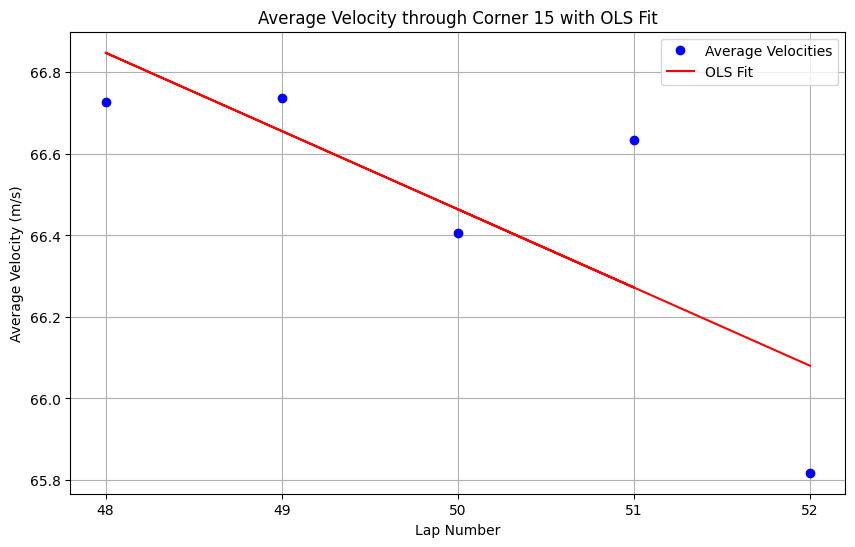

OLS Coefficients: Intercept = 76.06, Slope = -0.19


In [70]:

beta0, beta1 = OLS(lap_numbers, average_velocities)

plt.figure(figsize=(10, 6))
plt.plot(lap_numbers, average_velocities, 'o', label='Average Velocities', color='blue')
plt.plot(lap_numbers, beta0 + beta1 * lap_numbers, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity through Corner 15 with OLS Fit")
plt.legend()
plt.grid()
plt.xticks([48,49,50,51,52])
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.2f}")

## 3) Calculating the friction coefficient

Now we have all the tools we would like to calculate the friction coefficient.

In order to get started with the friction coefficient, we need to make a few assumptions:


1. Corner 15 is a perfect half circle. This means that the radius of the corner is constant, and the car is always at the same distance from the center of the corner.
2. The driver is driving at the maximum speed possible through the corner, which means that the car is at the limit of the tire's grip.
3. The track is flat, which means that there is no banking in the corner.



### 3a) Free body diagram

Draw a free body diagram of the car in turn 15. We want to include the direction of motion, the centripetal force and the centrifugal force.
The centripetal force is the force that keeps the car moving in a circular path, while the centrifugal force is the apparent force that acts outward on a body moving around a center. What we mean with "apparent" is that the centrifugal force is actually not a real force, but rather a result of inertia.
You can label the forces $F_c$ for the centripetal force and $F_f$ for the centrifugal force.


![Free body diagram of the car in turn 15](FBD.png)


### 3b) Finding $μ$

In this section, we want to find a formula for the friction coefficient $μ$.

The first assumption we made, allows us to use the formula for centripetal acceleration $a_c = \frac{v^2}{r}$, in order to find the friction coefficient $μ$.
Since the driver is driving at maximum velocity, at which the wheels can handle without slipping, we can say that the centripetal force, $F_c = ma _c$, is equal to the friction force, $F_f = μ N$. In other words, we can use Newtons third law to say that the centripetal force must equal to the friction force.

Find an expression for the friction coefficient $μ$, dependent on the average velocity, the radius and the mass.



Solution: 


### 3c) Create a function to calculate the friction coefficient

Create a function that takes in the average velocity and the radius of the corner, and returns the friction coefficient $μ$.

The function should use the formula you found in 3b.
The radius of the corner can be calculated from the length of the half circle, which is the distance between the start and end of the corner, using the formula:
$$r = \frac{L}{\pi}$$
where $L$ is the length of the half circle (corner).

In [ ]:
g = 9.81 # Acceleration due to gravity in m/s^2
length_of_corner = end_of_corner_15 - start_of_corner_15 # Length of the half circle in meters
radius_of_corner = length_of_corner / np.pi # Radius of the half circle in meters (from )

def mu(v: float, r: float) -> float:
    """Calculate the coefficient of friction required to maintain a given velocity in a circular path.
    
    Parameters:
    ----------
    v (float): Velocity in m/s.
    r (float): Radius of the circular path in meters.

    Returns:
    -------
    μ (float): Coefficient of friction required.

    """
    return v**2 / (g * r)


### 3d) Approximate the friction coefficient for corner 15 

Now we can combine the OLS function you created, with the friction coefficient function you just made, to find the slope to approximate the friction coefficient for corner 15.


In [ ]:
racer_keys = list(Racing_data.keys()) #List of racer keys

average_friction_coeff = []

for lap in lap_numbers:
    lap_friction_coeff = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        lap_friction_coeff.append(coeff)
    average_friction_coeff.append(np.mean(lap_friction_coeff))

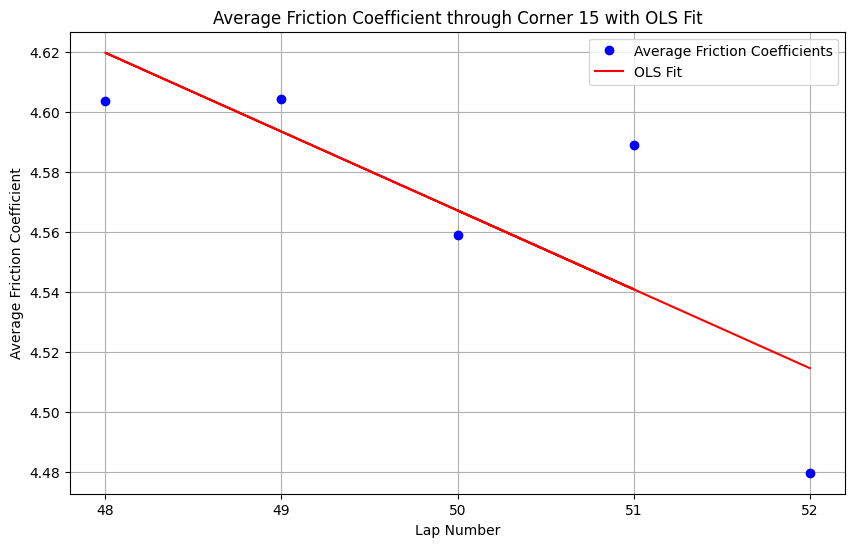

OLS Coefficients: Intercept = 5.88, Slope = -0.026


In [75]:
beta0, beta1 = OLS(lap_numbers, average_friction_coeff)

plt.figure(figsize=(10, 6))
plt.plot(lap_numbers, average_friction_coeff, 'o', label='Average Friction Coefficients', color='blue')
plt.plot(lap_numbers, beta0 + beta1 * lap_numbers, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Friction Coefficient")
plt.title("Average Friction Coefficient through Corner 15 with OLS Fit")
plt.legend()
plt.xticks([48,49,50,51,52])
plt.grid()
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.3f}")

If you have previously worked with friction coefficients, you might notice that friction coefficients usually are not that high. You might wonder what could have caused the high friction coefficient in this case. Do not worry, our next step is to include a factor that plays a huge role in formula 1 racing.

## 4) Improving the model

There is one thing about racing cars that we cannot ignore, and that is the downforce. Maybe the most remembered feature of the F1 cars is the huge rear wing, which is used to create downforce. The downforce is a force that pushes the car down onto the track, increasing the grip of the tires and allowing the car to go faster through corners.

So we will now have to include the downforce in our model, in order to get a more realistic friction coefficient.

### 4a) Downforce


Earlier we said that the friction force is equal to the centripetal force. But now that we introduce the downforce, we can say that the centripetal force is equal to the sum of the friction force and the downforce force:
$$
F_c = F_f + F_d
$$

where $F_d = μ C_D v²$

With the equations above, find a new expression for the friction coefficient $μ$.




Solution:
$$mv²/r = μ(mg + C_D v²)$$

$$μ = mv²/(r(mg + C_D v²))$$

### 4b) Create a function to calculate the new friction coefficient

Now it is time to create an improved function for the friction coefficient that takes into account the downforce.

Let us redefine the `mu` function to include the downforce term. The new function should include the downforce coefficient $C_D$, the mass of the car $m$, the radius of the corner $r$ and of course the average velocity $v$.

The mass of the car, including the racer, is approximately 800 kg, and the downforce coefficient $C_D$ is approximately 3.2, but can of course vary dependent on the cars.

#TODO: Make them google C_D???

In [ ]:
def mu(v: float, r: float, C_D: float = 3.2, m: float = 800) -> float:
    """Calculate the coefficient of friction required to maintain a given velocity in a circular path.
    
    Parameters:
    ----------
    v (float): Velocity in m/s.
    r (float): Radius of the circular path in meters.
    C_D (float): Drag coefficient (default is 3.2).
    m (float): Mass of the car in kg (default is 800).
    

    Returns:
    -------
    μ (float): Coefficient of friction required.
    """
    return m * v**2 / (r * (m * g + C_D * v**2))

### 4c) Approximate the new friction coefficient 

Now we can combine the OLS function you created, with the new friction coefficient function you just made, to find the new slope to approximate the friction coefficient for corner 15 with the downforce included.

In [80]:
racer_keys = list(Racing_data.keys()) #List of racer keys

average_friction_coeff = []

for lap in lap_numbers:
    lap_friction_coeff = []
    for racer in racer_keys:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,         
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        lap_friction_coeff.append(coeff)
    average_friction_coeff.append(np.mean(lap_friction_coeff))

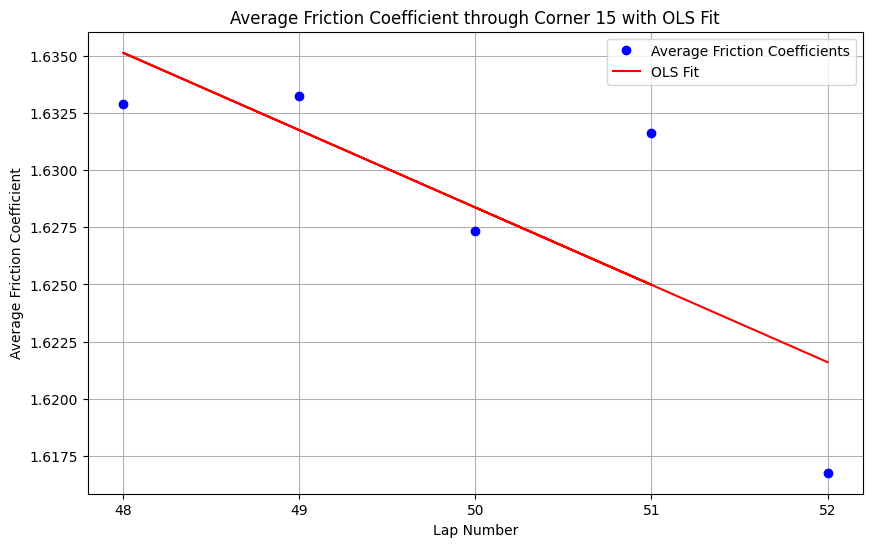

OLS Coefficients: Intercept = 1.80, Slope = -0.003


In [81]:

beta0, beta1 = OLS(lap_numbers, average_friction_coeff)

plt.figure(figsize=(10, 6))
plt.plot(lap_numbers, average_friction_coeff, 'o', label='Average Friction Coefficients', color='blue')
plt.plot(lap_numbers, beta0 + beta1 * lap_numbers, '-', label='OLS Fit', color='red')
plt.xlabel("Lap Number")
plt.ylabel("Average Friction Coefficient")
plt.title("Average Friction Coefficient through Corner 15 with OLS Fit")
plt.legend()
plt.xticks([48,49,50,51,52])
plt.grid()
plt.show()
print(f"OLS Coefficients: Intercept = {beta0:.2f}, Slope = {beta1:.3f}")

Usually, the tire friction coefficient of F1 cars is around 1.7, dependent on what tires they use. Pay notice to the slope of the line you just created. How does the friction coefficient change per lap? Does it make sense?

## 5) Individual friction coefficients

In this section, we want to attempt to calculate the individual friction coefficients for racer across the laps.

### 5a) Calculate the individual friction coefficients

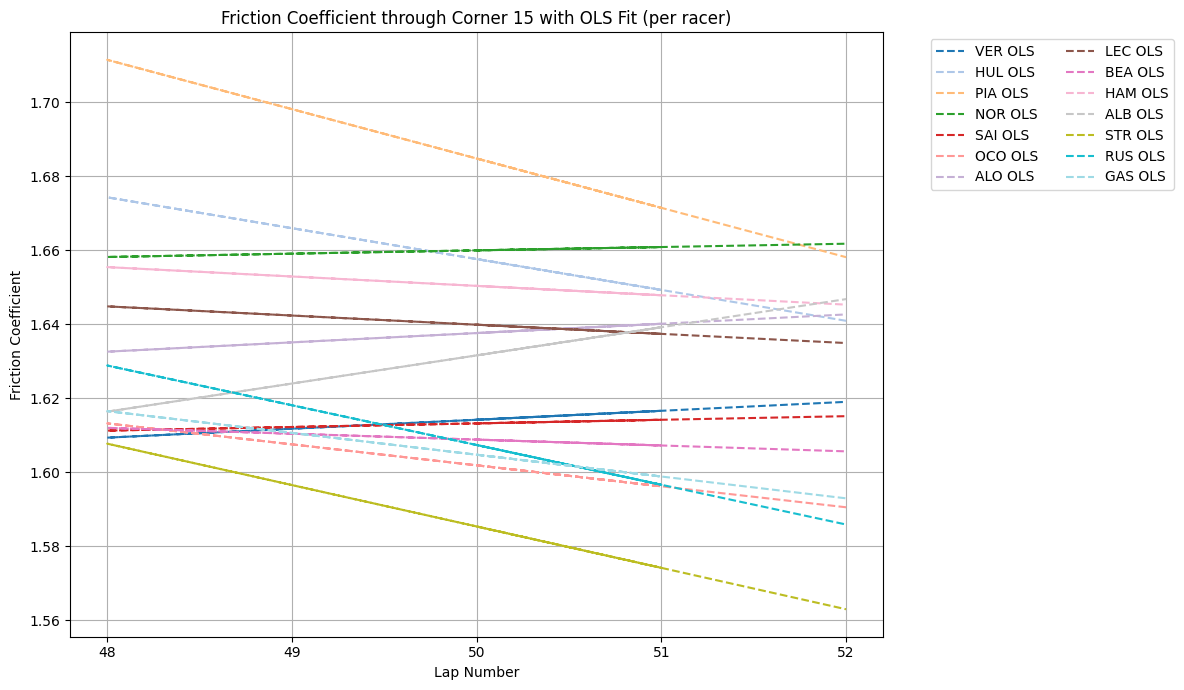

VER: Intercept = 1.493, Slope = 0.0024
HUL: Intercept = 2.075, Slope = -0.0083
PIA: Intercept = 2.352, Slope = -0.0133
NOR: Intercept = 1.615, Slope = 0.0009
SAI: Intercept = 1.564, Slope = 0.0010
OCO: Intercept = 1.885, Slope = -0.0057
ALO: Intercept = 1.512, Slope = 0.0025
LEC: Intercept = 1.764, Slope = -0.0025
BEA: Intercept = 1.688, Slope = -0.0016
HAM: Intercept = 1.777, Slope = -0.0025
ALB: Intercept = 1.251, Slope = 0.0076
STR: Intercept = 2.145, Slope = -0.0112
RUS: Intercept = 2.145, Slope = -0.0107
GAS: Intercept = 1.900, Slope = -0.0059


In [ ]:
racer_keys = list(Racing_data.keys())


plt.figure(figsize=(12, 7))

ols_results = {}

for i,racer in enumerate(racer_keys):
    racer_coeffs = []
    color = colors[i]
    for lap in lap_numbers:
        start_idx, end_idx = find_start_end_indices(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_of_corner=start_of_corner_15,### 1a) Create a function to calculate velocities

The first thing we will do is to create a function that inputs a racers data and returns the data with a new key `velocity`, which contains the velocities for each lap and each point in time. The function will iterate through the laps and calculate the velocities using the formula above.
            end_of_corner=end_of_corner_15
        )
        velocity = average_velocity(
            data=Racing_data,
            racer_key=racer,
            lap_number=lap,
            start_index=start_idx,
            end_index=end_idx
        )
        coeff = mu(velocity, radius_of_corner)
        racer_coeffs.append(coeff)
    racer_coeffs = np.array(racer_coeffs)
    # OLS fit for this racer
    beta0, beta1 = OLS(lap_numbers, racer_coeffs)
    ols_results[racer] = (beta0, beta1)
    plt.plot(lap_numbers, beta0 + beta1 * lap_numbers, '--', label=f"{racer} OLS", color=color)

plt.xlabel("Lap Number")
plt.ylabel("Friction Coefficient")
plt.title("Friction Coefficient through Corner 15 with OLS Fit (per racer)")
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.xticks([48,49,50,51,52])
plt.show()

# Print OLS coefficients for each racer
for racer, (beta0, beta1) in ols_results.items():
    print(f"{racer}: Intercept = {beta0:.3f}, Slope = {beta1:.4f}")

### 5b) Discuss the results

Now that we have printed individual friction coefficients for each racer, we can analyze the results.

- Discuss the meaning of the intercept term $β_0$, and its variance across racers.
<!--  -->
- Discuss also the slope $β_1$, and how it varies across racers. Does it make sense that some racers have a positive slope, while others have a negative slope? What could be the reason for this?



Looking at these individual regressions, we need to remember a few things. First, we set the same downforce coefficient $C_D$ for all racers, which most likely is not the case. Different racers have different setups, and therefore different downforce coefficients. Second, we are using the same mass for all racers, which is also not the case. Therefore, the intercept term $β_0$ will is most likely slightly elevated, or lower, than the actual friction coefficient. Keep also in mind that the intercept term $β_0$ is calculated to lap 0, and not the last pit stop. 

However the slope $β_1$ can still be interesting to look at. A positive slope means that the friction coefficient is increasing over the laps, which by itself does not make much sense. However, what it also means is that the racer managed to increase the speed through the corner, meaning the tires did not limit them to still perform at or above their previous levels.
A slope close to zero means can again point to the same thing, that the racer managed to maintain their speed through the corner, without losing grip or performance. 
However, a negative slope means that the racer is losing speed through the corner, which could be due to tire degradation, or simply that the racer is not performing as well as they did in the previous laps. 

### 5c) Predicting a winner

Below is a table of when the racers went into the pit stop. Use this information, along with the speed of the velocities from 1c and the individual friction coefficients from 5a and 5b, to pick three racers that you think performed the best in the final stages of the grand prix. Reason your choices based on the data you have analyzed. 


|Racer Name | Racer Key | Pit stop   |
|------------|-------|------------|
|Lando Norris| NOR   | Lap 11,44  | 
|Lance Stroll| STR   | Lap 6,10,41 | 
|Nico Hulkenberg| HUL   | Lap 9,42 | 
|George Russell| RUS   | Lap 10,38 | 
|Charles Leclerc| LEC   | Lap 10,42 | 
|Oliver Bearman| BEA   | Lap 10,41 | 
|Oscar Piastri| PIA   | Lap 11,43  | 
|Max Verstappen| VER   | Lap 11,41  | 
|Lewis Hamilton| HAM   | Lap 11,41  |  
|Pierre Gasly| GAS   | Lap 11,41  | 
|Fernando Alonso| ALO   | Lap 11,37  | 
|Carlos Sainz| SAI   | Lap 11,41  | 
|Alex Albon| ALB   | Lap 12,42  | 
|Esteban Ocon| OCO   | Lap 18,42  | 

Google the winner of the 2025 British Grand Prix, and see if your choices match the actual winner.



Solution:
The winner of the 2025 British Grand Prix was Lando Norris, who drove for McLaren. 



